Performance of NN 

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [3]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import sys
import glob

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc 


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.use('Agg')
%matplotlib inline

import utils
sys.path.append(".")
from utils import *

from tensorflow.python.keras.backend import set_session
from scipy.stats import pearsonr

CLASS_PARTIAL_LOSS = 0
CLASS_COMPLETELY_LOSS = 1 

TensorFlow 1.x selected.


Using TensorFlow backend.


In [12]:
def draw_confusion_matrix(y_test, y_pred):
  """
  Draw a confusion matrix based on the predictions and true labels
  :param y_test: np.array of the true labels
  :param y_pred: np.array of the predictions labels
  """
  cm = confusion_matrix(y_test, y_pred_keras)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

def get_prediction_based_on_wcgw(x_test):
  """
  Get a prediction of dataset using the wcgw rules
  """
  pred = []
  for i  in range(len(x_test)):
    mini_seq = x_test[i][73:77]
    if mini_seq in ["ACGA", "ACGT", "TCGA", "TCGT"]:
      pred.append(CLASS_COMPLETELY_LOSS)
    else:
      pred.append(CLASS_PARTIAL_LOSS)

  return pred

def get_prediction_based_on_flank(x_train_seq, y_train, x_test, flank_size=1):
  """
  Get a prediction of dataset using dictionary of flank
  :param x_train_seq: The train set for the dictionary learning phase 
  :param y_train: The train labels for the dictionary learning phase
  :param x_test: The test dataset to predict on
  :param flank_size: The amount of flank neucliotides to use for prediciton
  :return: The prediction for the x_test
  """
  one_label_factor = np.sum(y_train == 1)
  zero_label_factor = np.sum(y_train==0)
  seqs_dict = {}
  for i  in range(len(x_train_seq)):
    seq = x_train_seq[i]
    mini_seq = seq[74-flank_size:76+flank_size]

    if mini_seq not in seqs_dict:
      seqs_dict[mini_seq] = 0

    if y_train[i] == 1:
      seqs_dict[mini_seq] += one_label_factor
    else:
      seqs_dict[mini_seq] -=zero_label_factor

  pred = []
  for i in range(len(x_test)):
    seq = x_test[i]
    mini_seq = seq[74-flank_size:76+flank_size]
    if mini_seq not in seqs_dict:
      pred.append(1)
      continue
    
    majority_vote = seqs_dict[mini_seq]
    if majority_vote >0:
      pred.append(1)
    else:
      pred.append(0)

  return pred 

In [6]:
def get_nn_performace(data_path, scwgbs_models_folder, bulk_models_folder, title, other_data):
  """
  Print a ROC curve of the NN compare to other models
  :param data_path: Path for the data
  :param scwgbs_models_folder: Path for the scwgbs models
  :parma bulk_models_folder: Path for the bulk models
  :param title: Title for the ROC curve 
  :param other_data: Other dataset we need to check our test sequences doesn't contain to prevent testing on trained sequences
  """
  print("Loading data")
  _,_,_,_, x_test_seq, y_test, x_train_seq, _ = load_train_validate_test_data(data_path, 150, False, kfold=1)
  _, _,_,_,_,_, other_train_seq,_  = load_train_validate_test_data(other_data, 150, False, kfold=1)
  
  print("Removing bad sequences")
  trained_seq = vecs2dna(x_train_seq)
  other_seq_l = vecs2dna(other_train_seq)
  test_seq = vecs2dna(x_test_seq)
  
  shared =set(trained_seq + other_seq_l) & set(test_seq)
  good_indexes = [i for i in range(len(test_seq)) if test_seq[i] not in shared]
  x_test_seq, y_test = x_test_seq[good_indexes], y_test[good_indexes]
  test_seq = np.array(test_seq)[good_indexes]

  print("Load and predict on models")
  # Load the models 
  models_paths = glob.glob(os.path.join(scwgbs_models_folder, "*"))
  sc_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  models_paths = glob.glob(os.path.join(bulk_models_folder, "*"))
  bulk_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  # Get predictions using different models 
  sc_y_pred_keras  = predict(sc_models, x_test_seq).ravel()
  bulk_y_pred_keras  = predict(bulk_models, x_test_seq).ravel()
  
  # Get predictions based on flanking to compare to the nn
  print("Predict on basic models")
  wcgw_pred = get_prediction_based_on_wcgw(test_seq)

  precision_wcgw, recall_wcgw, _ = precision_recall_curve(y_test,wcgw_pred)
  average_precision_wcgw = average_precision_score(y_test,wcgw_pred)
  pr_auc_wcgw= auc(recall_wcgw,precision_wcgw)


  # flank1_pred = get_prediction_based_on_flank(trained_seq, y_train[0], test_seq, flank_size=1)
  # flank2_pred = get_prediction_based_on_flank(trained_seq, y_train[0], test_seq, flank_size=2)
  # flank3_pred = get_prediction_based_on_flank(trained_seq, y_train[0], test_seq, flank_size=3)

  print("Create roc curves")
  # Compute ROC curve and AUC 
  fpr_keras_sc, tpr_keras_sc, thresholds_keras_sc = roc_curve(y_test, sc_y_pred_keras)
  auc_keras_sc = auc(fpr_keras_sc, tpr_keras_sc)

  precision_sc, recall_sc, _ = precision_recall_curve(y_test,sc_y_pred_keras)
  average_precision_sc = average_precision_score(y_test,sc_y_pred_keras)
  pr_auc_sc= auc(recall_sc,precision_sc)

  fpr_keras_bulk, tpr_keras_bulk, thresholds_keras_bulk = roc_curve(y_test, bulk_y_pred_keras)
  auc_keras_bulk = auc(fpr_keras_bulk, tpr_keras_bulk)
  precision_bulk, recall_bulk, _ = precision_recall_curve(y_test,bulk_y_pred_keras)
  average_precision_bulk = average_precision_score(y_test,bulk_y_pred_keras)
  pr_auc_bulk= auc(recall_bulk,precision_bulk)

  fpr_wcgw,tpr_wcgw, thresholds_wcgw = roc_curve(y_test, wcgw_pred)
  auc_wcgw = auc(fpr_wcgw, tpr_wcgw)

  # fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, flank1_pred)
  # auc_1 = auc(fpr_1, tpr_1)

  # fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, flank2_pred)
  # auc_2 = auc(fpr_2, tpr_2)

  # fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, flank3_pred)
  # auc_3 = auc(fpr_3, tpr_3)

  plt.figure(1, dpi=200)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras_sc, tpr_keras_sc, label='Bian NN (area = {:.3f})'.format(auc_keras_sc))
  plt.plot(fpr_keras_bulk, tpr_keras_bulk, label='Zhou NN (area = {:.3f})'.format(auc_keras_bulk))
  # plt.plot(fpr_3, tpr_2, label='3-flank (area = {:.3f})'.format(auc_3))
  # plt.plot(fpr_2, tpr_2, label='2-flank (area = {:.3f})'.format(auc_2))
  # plt.plot(fpr_1, tpr_1, label='1-flank (area = {:.3f})'.format(auc_1))
  plt.plot(fpr_wcgw,tpr_wcgw, label='WCGW (area = {:.3f})'.format(auc_wcgw))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve %s' %title)
  plt.legend(loc='best')
  plt.show()

  plt.plot(recall_sc, precision_sc, lw=2, label="Bian NN (AP={0:0.2f})".format(average_precision_sc))
  plt.plot(recall_bulk, precision_bulk, lw=2, label="Zhou NN (AP={0:0.2f})".format(average_precision_bulk))
  plt.plot(recall_wcgw, precision_wcgw, lw=2, label="WCGW (AP={0:0.2f})".format(average_precision_wcgw))

  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision-Recall curve %s" %title)
  plt.legend(loc='best')
  plt.show()

In [7]:
def compare_shared_sequences_predictions(scwgbs_data, bulk_data, scwgbs_models_folder, bulk_models_folder):
  """
  Plot the difference in predictions for both NN models
  :param scwgbs_data: scWGBS dataset 
  :param bulk_data: Bulk dataset
  :param scwgbs_models_folder: Path for the scwgbs models
  :parma bulk_models_folder: Path for the bulk models
  """
  # scWGBS data and models
  print("Load data")
  _,_,_,_, sc_test_seq, sc_test_y,_,_ = load_train_validate_test_data(scwgbs_data, 150, True, kfold=1)
  models_paths = glob.glob(os.path.join(scwgbs_models_folder, "*"))
  sc_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]
  sc_pred  = predict(sc_models, sc_test_seq).ravel()

  sc_seq = vecs2dna(sc_test_seq)
  sc_pred_coupled = [(sc_pred[i],sc_test_y[i]) for i in range(sc_pred.shape[0])]
  sc_dict = dict(zip(sc_seq,sc_pred_coupled))
  
  _,_,_,_, bulk_test_seq, bulk_test_y,_,_ = load_train_validate_test_data(bulk_data, 150, True, kfold=1)
  models_paths = glob.glob(os.path.join(bulk_models_folder, "*"))
  bulk_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]
  bulk_pred  = predict(bulk_models, bulk_test_seq).ravel()
  bulk_seq = vecs2dna(bulk_test_seq)

  sc_pred_coupled = [(bulk_pred[i],bulk_test_y[i]) for i in range(bulk_pred.shape[0])]
  bulk_dict = dict(zip(bulk_seq,sc_pred_coupled))
  
  print("Removed shared sequences")
  # Get shared sequences 

  shared = set(bulk_seq) & set(sc_seq)
  predicted_shared = []
  for seq in shared:
    predicted_shared.append((bulk_dict[seq], sc_dict[seq]))
  
  # Calculate pearson correlation
  pc = [(i[0][0],i[1][0]) for i in predicted_shared]
  corr, _ = pearsonr([i[0] for i in pc], [i[1] for i in pc])
  print("Pearson correlation value is: %s" %corr)

  print("Calculate values for graph")
  bulk_ind = 0
  sc_index = 1
  pred_index=0
  label_index = 1
  hypo_resistant = 0
  hypo_prone = 1

  # Plot two graphs
  bulk_resist_resist = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_resistant and predicted_shared[i][sc_index][label_index] == hypo_resistant)]
  bulk_resist_prone = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_resistant and predicted_shared[i][sc_index][label_index] == hypo_prone)]
  bulk_prone_resist = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_prone and predicted_shared[i][sc_index][label_index] == hypo_resistant)]
  bulk_prone_prone = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_prone and predicted_shared[i][sc_index][label_index] == hypo_prone)]

  sc_resist_resist= [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_resistant and predicted_shared[i][sc_index][label_index] == hypo_resistant)]
  sc_resist_prone = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_resistant and predicted_shared[i][sc_index][label_index] == hypo_prone)]
  sc_prone_resist = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_prone and predicted_shared[i][sc_index][label_index] == hypo_resistant)]
  sc_prone_prone = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_prone and predicted_shared[i][sc_index][label_index] == hypo_prone)]

  plt.figure(1, dpi=200)
  plt.scatter(bulk_resist_resist, sc_resist_resist, marker=".",label="Resistant\Resistant (%s)" %len(bulk_resist_resist), c="b", alpha=0.3,s=1)
  plt.scatter(bulk_prone_prone, sc_prone_prone, marker="*",label="Prone/Prone (%s)" % len(sc_prone_prone), c="r",alpha=0.3,s=1)
  plt.scatter(bulk_resist_prone + bulk_prone_resist, sc_resist_prone+sc_prone_resist, marker=".",label="Disagree (%s)" %len(sc_resist_prone+sc_prone_resist), c="gray",s=1, alpha=0.5)


  plt.xlabel("NN score for Zhou dataset model")
  plt.ylabel("NN score for Bian dataset model")
  plt.title("Comparing NN scores of datasets")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale =2)

In [10]:
def get_nn_performace_against_flank(data_path, models_path, title):
  """
  Print a ROC curve of the NN compare to other models
  :param data_path: Path for the data
  :param models path: Path for the models
  :param title: Title for the ROC curve 
  """
  print("Loading data")
  _,_,_,_, x_test_seq, y_test, x_train_seq, y_train = load_train_validate_test_data(data_path, 150, False, kfold=1)
  
  print("Convert to seq info")
  test_seq = vecs2dna(x_test_seq)
  trained_seq = vecs2dna(x_train_seq)

  print("Load and predict on models")
  # Load the models 
  models_paths = glob.glob(os.path.join(models_path, "*"))
  models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  # Get predictions using different models 
  y_pred_keras  = predict(models, x_test_seq).ravel()
  
  # Get predictions based on flanking to compare to the nn
  print("Predict on basic models")
  # wcgw_pred = get_prediction_based_on_wcgw(test_seq)

  flank1_pred = get_prediction_based_on_flank(trained_seq, y_train, test_seq, flank_size=1)
  flank2_pred = get_prediction_based_on_flank(trained_seq, y_train, test_seq, flank_size=2)
  flank3_pred = get_prediction_based_on_flank(trained_seq, y_train, test_seq, flank_size=3)

  print("Create roc curves")
  # Compute ROC curve and AUC 
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)


  fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, flank1_pred)
  auc_1 = auc(fpr_1, tpr_1)

  fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, flank2_pred)
  auc_2 = auc(fpr_2, tpr_2)

  fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, flank3_pred)
  auc_3 = auc(fpr_3, tpr_3)

  plt.figure(1, dpi=200)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='NN (area = {:.3f})'.format(auc_keras))
  plt.plot(fpr_3, tpr_2, label='3-flank (area = {:.3f})'.format(auc_3))
  plt.plot(fpr_2, tpr_2, label='2-flank (area = {:.3f})'.format(auc_2))
  plt.plot(fpr_1, tpr_1, label='1-flank (area = {:.3f})'.format(auc_1))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve %s' %title)
  plt.legend(loc='best')
  plt.show()

Run the performances

In [ ]:
zhou_all_data = r"dataset/covariance/bulk_prone_0.0153/bulk.pkl"
zhou_models_folder="./models/folds_models/covariance/5-folds"


scwgbs_data = r"dataset/scwgbs_crc01_dataset/scwgbs1_crc01.pkl"
sc_models_folder="./models/folds_models/sc/5-folds"


Loading data
Removing bad sequences
Load and predict on models
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Predict on basic models
Create roc curves


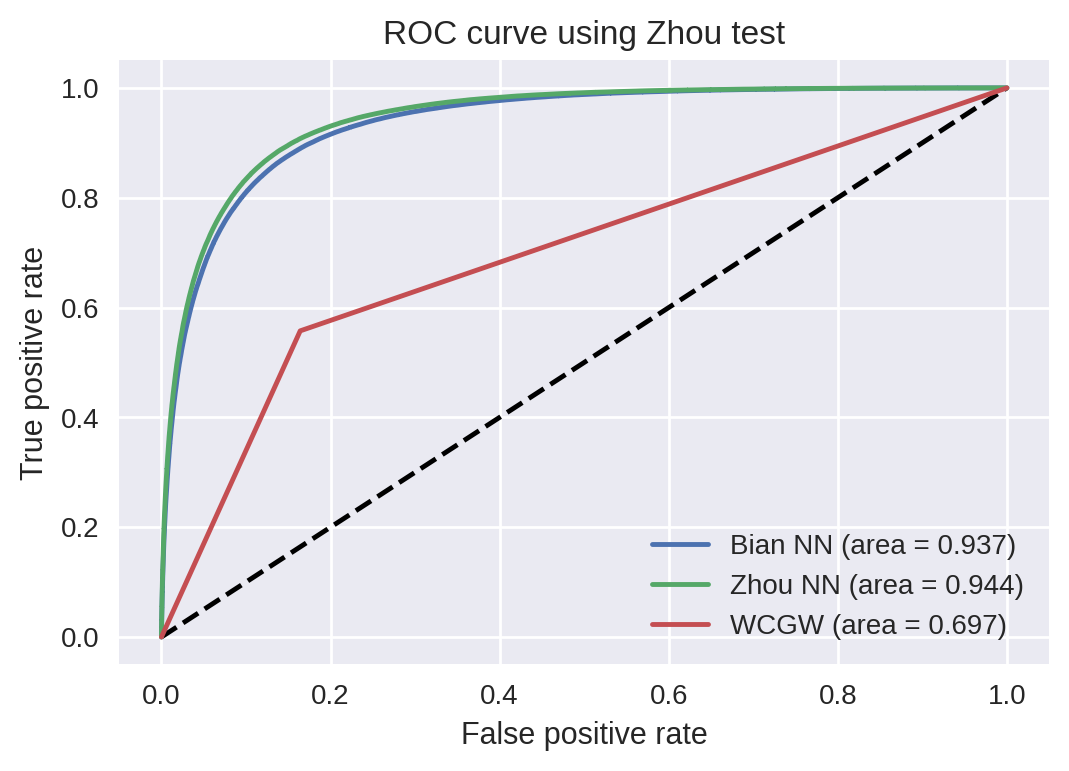

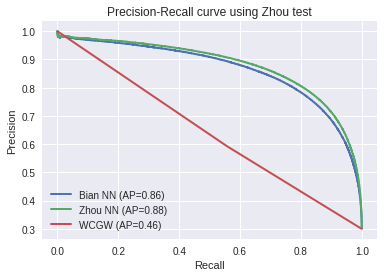

In [ ]:
# Get roc curve of bulk dataset
# get_nn_performace(data_path=zhou_data_path, models_folder=zhou_models_folder, title="Bulk dataset")
get_nn_performace(data_path=zhou_all_data, scwgbs_models_folder=sc_models_folder, bulk_models_folder=zhou_models_folder, title="using Zhou test", other_data=scgwbs_data)

Loading data
Removing bad sequences
Load and predict on models
Predict on basic models
Create roc curves


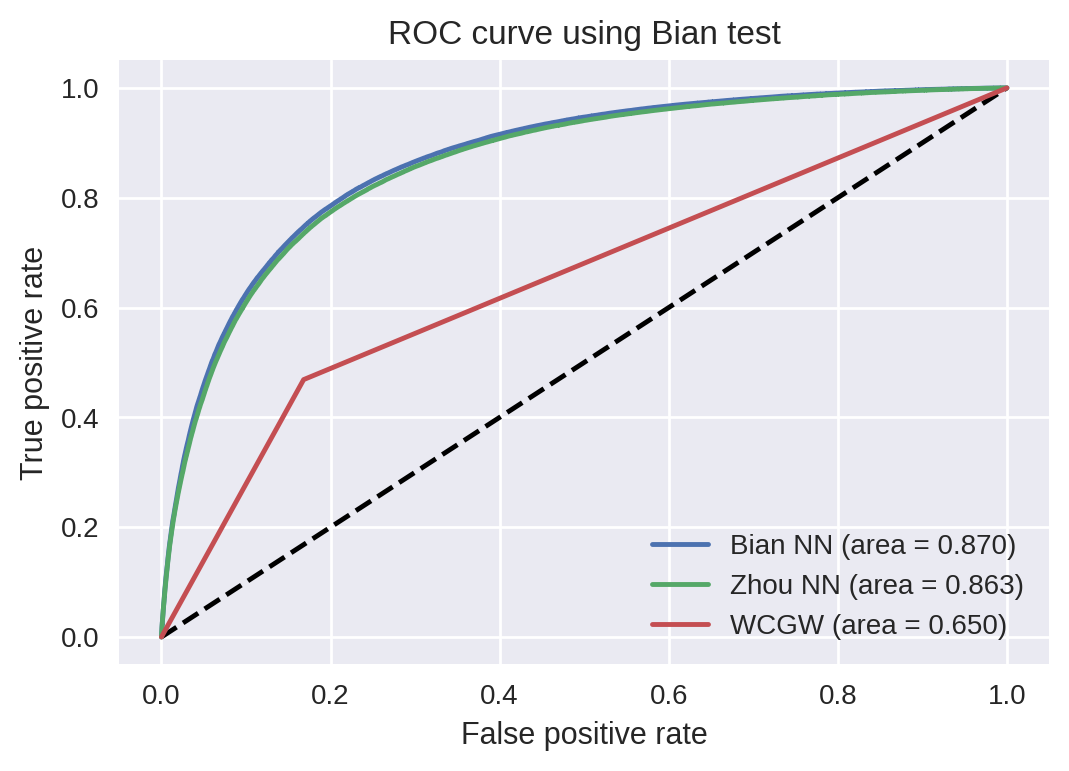

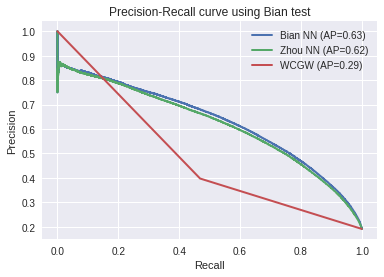

In [ ]:
get_nn_performace(other_data=zhou_all_data, scwgbs_models_folder=sc_models_folder, bulk_models_folder=zhou_models_folder, title="using Bian test", data_path=scgwbs_data)

In [ ]:
compare_shared_sequences_predictions(scwgbs_data=scgwbs_data, bulk_data=zhou_all_data, scwgbs_models_folder=sc_models_folder, bulk_models_folder=zhou_models_folder)

In [ ]:
zhou_models_folder="./models/folds_models/covariance/5-folds"
scwgbs_models_folder="./models/folds_models/sc/5-folds"

scwgbs_data = r"dataset/scwgbs_crc01_dataset/scwgbs1_crc01.pkl"
zhou_all_data = r"dataset/covariance/bulk_prone_0.0153/bulk.pkl"


In [ ]:
 print("Load data")
_,_,_,_, sc_test_seq, sc_test_y,_,_ = load_train_validate_test_data(scwgbs_data, 150, True, kfold=1)
models_paths = glob.glob(os.path.join(scwgbs_models_folder, "*"))
sc_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]
sc_pred  = predict(sc_models, sc_test_seq).ravel()

sc_seq = vecs2dna(sc_test_seq)
sc_pred_coupled = [(sc_pred[i],sc_test_y[i]) for i in range(sc_pred.shape[0])]
sc_dict = dict(zip(sc_seq,sc_pred_coupled))

_,_,_,_, bulk_test_seq, bulk_test_y,_,_ = load_train_validate_test_data(zhou_all_data, 150, True, kfold=1)
models_paths = glob.glob(os.path.join(zhou_models_folder, "*"))
bulk_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]
bulk_pred  = predict(bulk_models, bulk_test_seq).ravel()
bulk_seq = vecs2dna(bulk_test_seq)

sc_pred_coupled = [(bulk_pred[i],bulk_test_y[i]) for i in range(bulk_pred.shape[0])]
bulk_dict = dict(zip(bulk_seq,sc_pred_coupled))

print("Removed shared sequences")
# Get shared sequences 

shared = set(bulk_seq) & set(sc_seq)
predicted_shared = []
for seq in shared:
  predicted_shared.append((bulk_dict[seq], sc_dict[seq]))

# Calculate pearson correlation
pc = [(i[0][0],i[1][0]) for i in predicted_shared]
corr, _ = pearsonr([i[0] for i in pc], [i[1] for i in pc])
print("Pearson correlation value is: %s" %corr)


Calculate values for graph


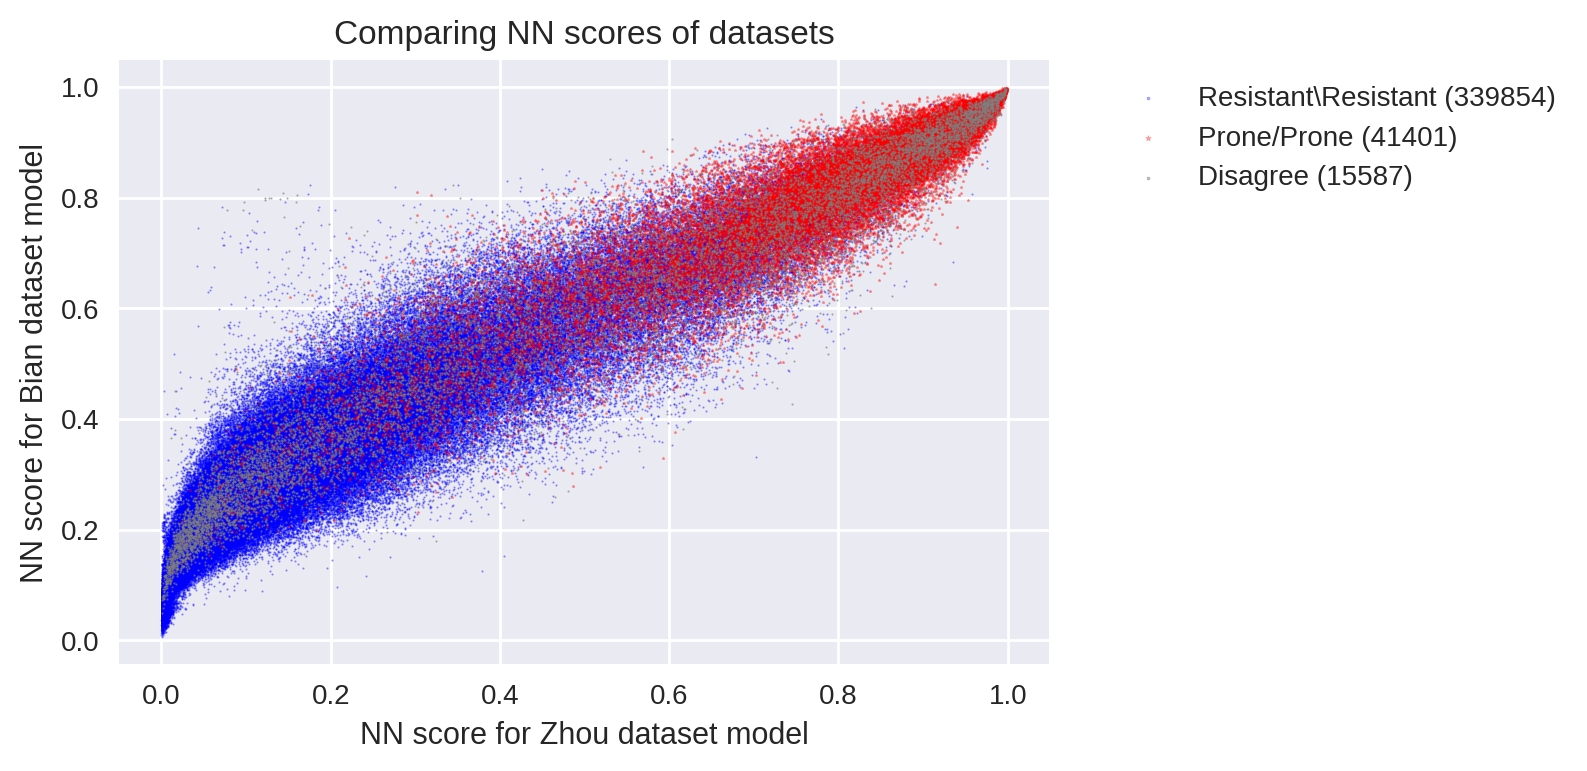

In [ ]:

print("Calculate values for graph")
bulk_ind = 0
sc_index = 1
pred_index=0
label_index = 1
hypo_resistant = 0
hypo_prone = 1

# Plot two graphs
bulk_resist_resist = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_resistant and predicted_shared[i][sc_index][label_index] == hypo_resistant)]
bulk_resist_prone = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_resistant and predicted_shared[i][sc_index][label_index] == hypo_prone)]
bulk_prone_resist = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_prone and predicted_shared[i][sc_index][label_index] == hypo_resistant)]
bulk_prone_prone = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_prone and predicted_shared[i][sc_index][label_index] == hypo_prone)]

sc_resist_resist= [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_resistant and predicted_shared[i][sc_index][label_index] == hypo_resistant)]
sc_resist_prone = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_resistant and predicted_shared[i][sc_index][label_index] == hypo_prone)]
sc_prone_resist = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_prone and predicted_shared[i][sc_index][label_index] == hypo_resistant)]
sc_prone_prone = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo_prone and predicted_shared[i][sc_index][label_index] == hypo_prone)]

plt.figure(1, dpi=200)
plt.scatter(bulk_resist_resist, sc_resist_resist, marker=".",label="Resistant\Resistant (%s)" %len(bulk_resist_resist), c="b", alpha=0.3,s=1)
plt.scatter(bulk_prone_prone, sc_prone_prone, marker="*",label="Prone/Prone (%s)" % len(sc_prone_prone), c="r",alpha=0.3,s=1)
plt.scatter(bulk_resist_prone + bulk_prone_resist, sc_resist_prone+sc_prone_resist, marker=".",label="Disagree (%s)" %len(sc_resist_prone+sc_prone_resist), c="gray",s=1, alpha=0.5)


plt.xlabel("NN score for Zhou dataset model")
plt.ylabel("NN score for Bian dataset model")
plt.title("Comparing NN scores of datasets")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale =2)

Loading data
Convert to seq info
Load and predict on models
Predict on basic models
Create roc curves


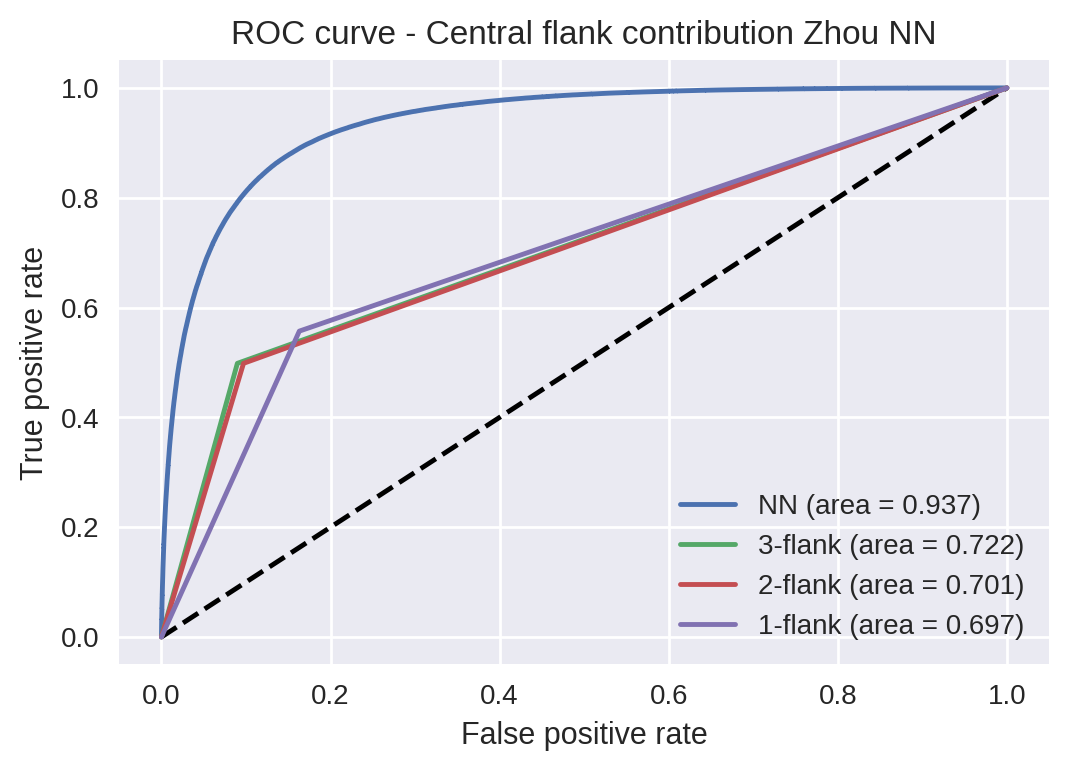

In [ ]:
title = "- Central flank contribution Zhou NN"
zhou_all_data = r"dataset/covariance/bulk_prone_0.0153/bulk.pkl"
zhou_models_folder="./models/folds_models/covariance/5-folds"

get_nn_performace_against_flank(zhou_all_data, zhou_models_folder, title)

In [ ]:
title = "- Central flank contribution Bian NN"
zhou_models_folder="./models/folds_models/covariance/5-folds"
scwgbs_models_folder="./models/folds_models/sc/5-folds"

scwgbs_data = r"dataset/scwgbs_crc01_dataset/scwgbs1_crc01.pkl"
zhou_all_data = r"dataset/covariance/bulk_prone_0.0153/bulk.pkl"


get_nn_performace_against_flank(scwgbs_data, scwgbs_models_folder, title)

Loading data
